In [1]:
import os
import itertools
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator
)

C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)


C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\Scripts\python.exe


In [3]:
import os
import random
import shutil

DATA_DIR = r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VALID_DIR, exist_ok=True)

# liste des fichiers images (ajuste extensions si besoin)
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

random.shuffle(files)

split = int(0.8 * len(files))
train_files = files[:split]
valid_files = files[split:]

for f in train_files:
    shutil.move(os.path.join(DATA_DIR, f), os.path.join(TRAIN_DIR, f))

for f in valid_files:
    shutil.move(os.path.join(DATA_DIR, f), os.path.join(VALID_DIR, f))

print("Train:", len(os.listdir(TRAIN_DIR)))
print("Valid:", len(os.listdir(VALID_DIR)))


Train: 527
Valid: 132


In [4]:
import os
import pandas as pd

train_path = r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie\train"

train_dir_list = os.listdir(train_path)

train_df = pd.DataFrame(train_dir_list, columns=["file_name"])

train_df["text"] = train_df["file_name"].map(
    lambda x: x.split(".")[0]
)

train_df.head()

,file_name,text
0,228.png,228
1,23eu.png,23eu
2,23hq.png,23hq
3,24u.png,24u
4,24y6v.png,24y6v


In [5]:
valid_path = r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie\valid"

valid_dir_list = os.listdir(valid_path)

valid_df = pd.DataFrame(valid_dir_list, columns=["file_name"])

valid_df["text"] = valid_df["file_name"].map(
    lambda x: x.split(".")[0]
)

valid_df.head()

,file_name,text
0,28p.png,28p
1,2du.png,2du
2,2gmsg.png,2gmsg
3,2s6x3.png,2s6x3
4,34bm.png,34bm


In [6]:
# test_path = "/Users/theo/Desktop/data_russie/test"

# test_dir_list = os.listdir(test_path)

# test_df = pd.DataFrame(test_dir_list, columns=["file_name"])

# test_df["text"] = test_df["file_name"].map(
#     lambda x: x.split(".")[0]
# )

# test_df.head()

In [7]:
class Captcha_Dataset(Dataset):

    def __init__(self, root_dir, df, processor, max_target_length=10):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        file_name = self.df.iloc[idx]["file_name"]
        text = self.df.iloc[idx]["text"]

        image = Image.open(
            os.path.join(self.root_dir, file_name)
        ).convert("RGB")

        pixel_values = self.processor(
            image,
            return_tensors="pt"
        ).pixel_values.squeeze()

        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True
        ).input_ids

        labels = [
            l if l != self.processor.tokenizer.pad_token_id else -100
            for l in labels
        ]

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(labels)
        }

In [8]:
MODEL_CKPT = "microsoft/trocr-base-printed"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "_captcha_ocr"

NUM_OF_EPOCHS = 5

In [9]:
from transformers import TrOCRProcessor

MODEL_CKPT = "microsoft/trocr-base-printed"

processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

In [10]:
train_ds = Captcha_Dataset(
    root_dir=train_path,
    df=train_df,
    processor=processor
)

valid_ds = Captcha_Dataset(
    root_dir=valid_path,
    df=valid_df,
    processor=processor
)

# test_ds = Captcha_Dataset(
#     root_dir=test_path,
#     df=test_df,
#     processor=processor
# )

In [11]:
print(f"The training dataset has {len(train_ds)} samples in it.")
# print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 527 samples in it.


In [12]:

encoding = train_ds[10]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([10])


(np.float64(-0.5), np.float64(119.5), np.float64(71.5), np.float64(-0.5))

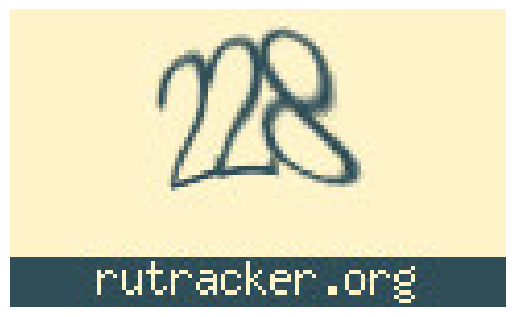

In [13]:
import matplotlib.pyplot as plt

idx = 0

img_path = os.path.join(train_path, train_df.iloc[idx]["file_name"])
image = Image.open(img_path).convert("RGB")

plt.imshow(image)
plt.axis("off")

In [14]:
encoding = train_ds[idx]

labels = encoding["labels"].clone()
labels[labels == -100] = processor.tokenizer.pad_token_id

label_str = processor.decode(labels, skip_special_tokens=True)

print("Label:", label_str)

Label: 228


In [15]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

Loading weights: 100%|█| 478/478 [00:01<00:00, 311.45it/s, Materializing param=encoder
VisionEncoderDecoderModel LOAD REPORT from: microsoft/trocr-base-printed
Key                         | Status  | 
----------------------------+---------+-
encoder.pooler.dense.weight | MISSING | 
encoder.pooler.dense.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [16]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 10
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"./{MODEL_NAME}",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,

    eval_strategy="steps",
    logging_first_step=True,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,

    warmup_steps=200,
    learning_rate=5e-5,
    num_train_epochs=NUM_OF_EPOCHS,
    save_total_limit=2,
    fp16=False,
    report_to="none",
    disable_tqdm=False,
    logging_strategy="steps"
)

In [18]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=default_data_collator,
)

In [19]:
trainer.train()

C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Sauvegarde du modèle et du processor
trainer.save_model(f"./{MODEL_NAME}")
processor.save_pretrained(f"./{MODEL_NAME}")

print("Modèle sauvegardé dans :", f"./{MODEL_NAME}")

In [ ]:
# Évaluation sur test
metrics = trainer.evaluate(test_ds)

print("Résultats test:")
for k, v in metrics.items():
    print(f"{k}: {v}")

In [ ]:
def predict_captcha(image_path, model, processor, device="cpu"):

    image = Image.open(image_path).convert("RGB")

    pixel_values = processor(
        image,
        return_tensors="pt"
    ).pixel_values.to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    pred = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )[0]

    return pred

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

model = VisionEncoderDecoderModel.from_pretrained(f"./{MODEL_NAME}")
processor = TrOCRProcessor.from_pretrained(f"./{MODEL_NAME}")

model.eval()

print("Modèle chargé.")

In [ ]:
# Test sur 10 images
for img in os.listdir(TEST_DIR)[:10]:

    path = os.path.join(TEST_DIR, img)

    pred = predict_captcha(path, model, processor)

    true = img.split(".")[0]

    print(f"GT: {true} | Pred: {pred}")

In [2]:
!pip install -U protobuf sentencepiece tiktoken

In [4]:
# =========================================================
# TrOCR CAPTCHA PIPELINE — ONE BLOCK (CPU friendly, HF-safe)
# Train/Val split + Augmentation + Phase A (fast) + Phase B (benchmark)
# Metrics: CER + Exact (Phase B only)
# =========================================================

import os, random, shutil
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter

import torch
from torch.utils.data import Dataset

from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator,
    GenerationConfig
)

# -------------------------
# 0) CONFIG
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

TRAIN_FRAC = 0.9
MAX_LEN = 6  # captcha souvent 4-6 -> accélère la génération

MODEL_CKPT = "microsoft/trocr-small-printed"
OUT_DIR_A = "./trocr_phaseA"
OUT_DIR_B = "./trocr_phaseB"
FINAL_DIR = "./trocr_final"

# -------------------------
# 1) TRAIN / VAL SPLIT (COPY)
# -------------------------
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

if len(os.listdir(TRAIN_DIR)) == 0 and len(os.listdir(VAL_DIR)) == 0:
    files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith((".png",".jpg",".jpeg"))]
    random.shuffle(files)
    n_train = int(TRAIN_FRAC * len(files))

    train_files = files[:n_train]
    val_files   = files[n_train:]

    for f in train_files:
        shutil.copy(os.path.join(DATA_DIR, f), os.path.join(TRAIN_DIR, f))
    for f in val_files:
        shutil.copy(os.path.join(DATA_DIR, f), os.path.join(VAL_DIR, f))

print("Train:", len([f for f in os.listdir(TRAIN_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]))
print("Val  :", len([f for f in os.listdir(VAL_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]))

# -------------------------
# 2) BUILD LABEL DFS (label = filename stem)
# -------------------------
def build_df(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith((".png",".jpg",".jpeg"))]
    df = pd.DataFrame(files, columns=["file_name"])
    df["text"] = df["file_name"].apply(lambda x: x.rsplit(".", 1)[0].lower())
    return df

train_df = build_df(TRAIN_DIR)
val_df   = build_df(VAL_DIR)

# -------------------------
# 3) AUGMENTATION (captcha-ish)
# -------------------------
def augment_image(img: Image.Image) -> Image.Image:
    if random.random() < 0.5:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    if random.random() < 0.5:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.3))
    if random.random() < 0.2:
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, 5, arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        img = Image.fromarray(arr)
    if random.random() < 0.15:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3, 0.8)))
    return img

# -------------------------
# 4) PROCESSOR
# -------------------------
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

# -------------------------
# 5) DATASET (robust pixel_values indexing)
# -------------------------
class CaptchaDataset(Dataset):
    def __init__(self, folder, df, processor, max_length=6, augment=False):
        self.folder = folder
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.loc[idx, "file_name"]
        text = self.df.loc[idx, "text"]

        img_path = os.path.join(self.folder, file_name)
        image = Image.open(img_path).convert("RGB")
        if self.augment:
            image = augment_image(image)

        pixel_values = self.processor(image, return_tensors="pt").pixel_values[0]  # ✅ safe

        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        ).input_ids
        labels = [l if l != self.processor.tokenizer.pad_token_id else -100 for l in labels]

        return {"pixel_values": pixel_values, "labels": torch.tensor(labels, dtype=torch.long)}

train_ds = CaptchaDataset(TRAIN_DIR, train_df, processor, max_length=MAX_LEN, augment=True)
val_ds   = CaptchaDataset(VAL_DIR, val_df, processor, max_length=MAX_LEN, augment=False)

# -------------------------
# 6) METRICS (Phase B only)
# -------------------------
def levenshtein(a: str, b: str) -> int:
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    prev = list(range(m + 1))
    for i in range(1, n + 1):
        cur = [i] + [0] * m
        ai = a[i - 1]
        for j in range(1, m + 1):
            cost = 0 if ai == b[j - 1] else 1
            cur[j] = min(prev[j] + 1, cur[j - 1] + 1, prev[j - 1] + cost)
        prev = cur
    return prev[m]

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    pred_str = processor.batch_decode(preds, skip_special_tokens=True)

    labels = labels.copy()
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    exact = float(np.mean([p == l for p, l in zip(pred_str, label_str)]))

    edits, chars = 0, 0
    for p, l in zip(pred_str, label_str):
        edits += levenshtein(p, l)
        chars += len(l)

    cer = edits / max(1, chars)
    return {"exact_acc": exact, "cer": cer}

# -------------------------
# 7) MODEL + HF-SAFE GENERATION CONFIG
# -------------------------
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.generation_config = GenerationConfig.from_model_config(model.config)
model.generation_config.max_length = MAX_LEN
model.generation_config.num_beams = 1  # greedy

# =========================================================
# 8) PHASE A — FAST ADAPT (freeze encoder, loss only, NO generate)
# =========================================================
for p in model.encoder.parameters():
    p.requires_grad = False

args_A = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR_A,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-5,
    num_train_epochs=4,
    warmup_steps=20,

    eval_strategy="epoch",
    save_strategy="epoch",

    predict_with_generate=False,     # ✅ faster
    logging_strategy="epoch",

    fp16=False,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args_A,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=default_data_collator,
    compute_metrics=None,            # ✅ Phase A = loss only
)

print("\n===== PHASE A (freeze encoder, fast) =====")
trainer.train()
print("\n===== VAL RESULTS (Phase A) =====")
print(trainer.evaluate())

# =========================================================
# 9) PHASE B — BENCHMARK (unfreeze, generate ON, CER/Exact)
# =========================================================
for p in model.encoder.parameters():
    p.requires_grad = True

args_B = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR_B,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    warmup_steps=10,

    eval_strategy="epoch",
    save_strategy="epoch",

    predict_with_generate=True,      # ✅ metrics need generate()
    logging_strategy="epoch",

    fp16=False,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args_B,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,  # ✅ Phase B metrics
)

print("\n===== PHASE B (unfreeze encoder, benchmark) =====")
trainer.train()
print("\n===== FINAL VAL RESULTS (TrOCR) =====")
print(trainer.evaluate())

trainer.save_model(FINAL_DIR)
processor.save_pretrained(FINAL_DIR)
print(f"\nSaved model+processor to: {FINAL_DIR}")


Train: 527
Val  : 65


Loading weights: 100%|█| 360/360 [00:01<00:00, 188.99it/s, Materializing param=encoder
VisionEncoderDecoderModel LOAD REPORT from: microsoft/trocr-small-printed
Key                         | Status  | 
----------------------------+---------+-
encoder.pooler.dense.bias   | MISSING | 
encoder.pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



===== PHASE A (freeze encoder, fast) =====


C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss
1,4.533872,2.683761
2,2.584024,2.363312
3,2.242824,2.159060
4,2.049827,2.101222


Writing model shards: 100%|█████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]
C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|█████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]
C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|█████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]
C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then devi


===== VAL RESULTS (Phase A) =====


C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 2.1012215614318848, 'eval_runtime': 50.4296, 'eval_samples_per_second': 1.289, 'eval_steps_per_second': 0.337, 'epoch': 4.0}

===== PHASE B (unfreeze encoder, benchmark) =====


Epoch,Training Loss,Validation Loss


OverflowError: can't convert negative int to unsigned

In [10]:
# ===============================
# PHASE B — continue finetuning from Phase A
# ===============================

import numpy as np
import torch
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator,
    GenerationConfig
)

# -------- CONFIG --------
BASE_MODEL = "microsoft/trocr-small-printed"
MODEL_A_DIR = "trocr_phaseA/checkpoint-528"   # 🔥 ton checkpoint
OUT_DIR_B = "./trocr_phaseB"
MAX_LEN = 6

# -------- LOAD MODEL + PROCESSOR --------
processor = TrOCRProcessor.from_pretrained(BASE_MODEL)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_A_DIR)

model.generation_config = GenerationConfig.from_model_config(model.config)
model.generation_config.max_length = MAX_LEN
model.generation_config.num_beams = 1

# -------- UNFREEZE ENCODER --------
for p in model.encoder.parameters():
    p.requires_grad = True

# -------- METRICS --------
def levenshtein(a, b):
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    prev = list(range(m + 1))
    for i in range(1, n + 1):
        cur = [i] + [0] * m
        for j in range(1, m + 1):
            cost = 0 if a[i-1] == b[j-1] else 1
            cur[j] = min(prev[j] + 1, cur[j-1] + 1, prev[j-1] + cost)
        prev = cur
    return prev[m]

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # preds may contain -100 -> cast to int
    preds = np.clip(preds, 0, processor.tokenizer.vocab_size - 1)

    pred_str = processor.batch_decode(preds, skip_special_tokens=True)

    labels = labels.copy()
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    exact = np.mean([p == l for p, l in zip(pred_str, label_str)])

    edits, chars = 0, 0
    for p, l in zip(pred_str, label_str):
        edits += levenshtein(p, l)
        chars += len(l)

    cer = edits / max(1, chars)
    return {"exact_acc": exact, "cer": cer}

# -------- TRAINING ARGS --------
args_B = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR_B,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    warmup_steps=10,

    eval_strategy="epoch",
    save_strategy="epoch",

    predict_with_generate=True,
    logging_strategy="epoch",

    fp16=False,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args_B,
    train_dataset=train_ds,   # ⚠️ tu gardes tes datasets existants
    eval_dataset=val_ds,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

print("===== PHASE B =====")
trainer.train()

print("===== FINAL RESULTS =====")
print(trainer.evaluate())

trainer.save_model("./trocr_final")
print("Model saved in ./trocr_final")


Loading weights: 100%|█| 362/362 [00:01<00:00, 195.90it/s, Materializing param=encoder


===== PHASE B =====


Epoch,Training Loss,Validation Loss,Exact Acc,Cer
1,1.406790,0.995753,0.261538,0.290196
2,0.855281,0.869637,0.400000,0.239216
3,0.600352,0.807607,0.446154,0.243137


Writing model shards: 100%|█████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]
C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|█████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]
C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|█████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


===== FINAL RESULTS =====


C:\Mosef\webscrapping\projet\Captchas-Automatic-Resolution\.venv\lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.8696371912956238, 'eval_exact_acc': 0.4, 'eval_cer': 0.23921568627450981, 'eval_runtime': 105.9611, 'eval_samples_per_second': 0.613, 'eval_steps_per_second': 0.16, 'epoch': 3.0}


Writing model shards: 100%|█████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]

Model saved in ./trocr_final
